# DS - Application Project <br>
# Developement of a Recommender System for Employee Skills - Binary Approach

## Preprocessing

Packages:

In [19]:
import implicit
#import h5py
import pandas as pd
import numpy as np
# from implicit.evaluation import train_test_split
# from implicit.nearest_neighbours import (
#     normalize,
#     bm25_weight
# )
import scipy
from scipy.sparse import csr_matrix
import scipy.sparse
# from implicit.lmf import LogisticMatrixFactorization
from implicit.evaluation import precision_at_k,mean_average_precision_at_k, ndcg_at_k
from random import shuffle
import itertools
import copy
from matplotlib import pyplot as plt


Import data:

In [20]:
df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";") 
df.head(5)

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem


DataFrame that assigns a category to every skill:

In [21]:
data_categories = df[["skill","category"]].drop_duplicates()
data_categories.head(5)

,skill,category
0,Windows NT/2000/XP,Betriebssystem
1,MAC OS X,Betriebssystem
2,Windows 7,Betriebssystem
3,Windows 8,Betriebssystem
4,iOS,Betriebssystem


In [22]:
data_categories[data_categories.category=="Umgebungen"]

,skill,category
19,NetBeans,Umgebungen
20,IntelliJ(Idea),Umgebungen
77,Visual Studio,Umgebungen
155,PhpStorm,Umgebungen
175,Workbench,Umgebungen
204,Pimcore,Umgebungen
237,JBuilder,Umgebungen
238,Ultra Edit,Umgebungen
239,Oracle Forms,Umgebungen
484,SharpDevelop,Umgebungen


Declaring various aiding variables

In [23]:
PERSONS = df["person"].unique()
SKILLS = sorted(df["skill"].unique())
CATEGORIES = df["category"].unique()
employee_dict = {}
for n in range(0,len(PERSONS)):
    employee_dict[n] = PERSONS[n]

In [24]:
skills_to_category = pd.read_csv("data/mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

Data cleaning: <br> <br>
In order to evaluate the effect of inputmatrices  (APPENDIX XY) with a different level of sparsity, it is reasonable to introduce a function, that allows us to drop rare skills, that occur less than x times in the dataset. Sparsity is here defined as the relationship of ones and zeros inside a user-item-matrix, where ones represent, that a user is proficient in a certain skill. On the other hand a zero inside a user-item-matrix represents that a user has no knowledge about cetrain skill. Accordingly rare skills are responsible for many zeros inside the user-item-matrix. By dropping these rare skills the total amount of zeros is reduced and therefore the matrix becomes less sparse.

In [25]:
def get_rare_skills(data:pd.DataFrame, n:int):
    '''
    Function to determine all skills which occur less than n times in a given dataset.
    Dataset must be a pandas Dataframe with columns: person, skill.
    ----------
    Parameters: 
    data : pd.DataFrame
    The data in which rare skills are to be determined. 
    n : int 
    The threshold frequency.
    ----------
    Returns: 
    List of skills occuring less than n times in dataset.
    '''
    skill_frequency = {}
    for skill in data["skill"].unique():
        skill_frequency[skill] = data[data["skill"] == skill]["person"].nunique()

    return [s for s,f in skill_frequency.items() if f <= n]


***for insights in why no skills are dropped please refer to Appendix I***

In [26]:
rare_skills = get_rare_skills(df,0)
df = df[~df["skill"].isin(rare_skills)]


In [27]:
df.shape

(24586, 3)

The implicit library works with sparse-matrices. In order to transform a dataset into its sparse representation the dataset must be restructured in the following way: <br>
* Each row represents a user
* Each column represents a item/skill
* Each entity represents whether a user is proficient in a skill or not

In [28]:
# Create a user-item matrix
df["count"] = 1
data_skills = df.pivot_table('count', index='person', columns="skill").fillna(0).astype(int).reset_index(drop=True)
#Set the index name = "userid"
data_skills.index.names = ["userids"]
data_skills

skill,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,AIX,ARIS,ARIS ITArchitect,AS400,...,ramda.js,ranorex,samba,script.aculo.us,varnish,visual paradigm,vnc,vs code,xHTML,xtCommerce
userids,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now the matrix can be transformed into its sparse representation

In [29]:
data_skills_csr = scipy.sparse.csr_matrix(data_skills.values)
type(data_skills_csr)

scipy.sparse._csr.csr_matrix

Normalizing the data:

In the following a function will be introduced that performs different normalization techniques on the dataset. The idea behind **row normalization** in its simples form (here: implicit.nearest_neighbours.normalizeI) is, that a certain skill is more valuable for a user with a small skill set than for a user with a very large skill set. The following toy example will demonstrate this effect:
* Lets assume, that we want to investigate how important the skill "Python" is for user A and user B.
* The skill set of user A includes 10 different skills.
* The skill set of user B includes 100 different skills
* In our unnormalized dataset the importance of Python would be represented by a 1 for both users - no matter how large their skill set is. Hence the importance for both users is equal.
* However on the normalized dataset importance of "Python" would be larger for user A than for user B, because of the different size of their skillset.

While normalization only respects a single skill set at once in its calculation, the techniques **TF-IDF** and **bm25** techniques expand the idea of measureing skill importance by considering all skill sets in their computation. <br>

***For more detailed insights in these techniques please have a look at our documentation.*** 


In [30]:
bm25_grid  = {
            'K1': [50,100,120]#,20,50,100
            ,'B': [0.75,1] # 0.4,0.8,1
            }

# param_grid_bm25  = {'K1': [2,50,100], #2,20,50,100
#                     'B': [ 0.4,0.8,1] # 0.4,0.8,1
#                     }

In [31]:
def normalizer (data:csr_matrix ,param_grid:dict):
    '''
    Function to perform different normalization techniques on a user-item-matrix, where the users are represented in the rows and the items in the columns.
    The following techniques will be performed:
    - Raw (no normalization technique)
    - Normalization
    - tfidf
    - bm25
    ----------
    Parameters: 
    data : csr_matrix
    The data in sparse csr format which will be normalized. 
    param_grid : dict 
    A dictonary that holds different values for the parameters of implicit's bm25_weight.
    The dictonary must consist of the following key value pairs:
    - K1 : list of floats
    - B : list of floats
    ----------
    Returns: 
    - List holding the transformed dataset.
    - Pandas DataFrame, where each row provides information about the performed transformation. 
      The first row provides information about the first element in the returned list, the second row about the second element in the returned list and so on. 
    '''
    data_representations = ['Raw','Normalized', 'tfidf', 'bm25']    
    df_list = []
    data_list = []


    for representation in data_representations:
        df = pd.DataFrame(columns = ['data_representations', 'K1', 'B'])

        if representation == 'bm25':
            keys, values = zip(*param_grid.items())
            for c,v in enumerate(itertools.product(*values)):
                params = dict(zip(keys, v))
                
                #############
                # Initiate df for the parameter combination
                #############
                df = pd.DataFrame()
                df = pd.DataFrame(params, index =  [c])
                df["data_representations"] = [representation]
                df_list.append(df)

                #############
                # Add key value pair to the dictonary and initiate the bm25_weight function for every parameter combination
                #############
                params['X'] = data
                data_transf = implicit.nearest_neighbours.bm25_weight(**params)
                data_list.append(data_transf)
        else:

            match representation:
                case 'Normalized':
                    data_transf = implicit.nearest_neighbours.normalize(data)
                case 'tfidf':
                    data_transf = implicit.nearest_neighbours.tfidf_weight(data)
                case 'Raw':
                    data_transf = data
            df["data_representations"] = [representation]
            df["K1"] = np.nan
            df["B"] = np.nan  
            df_list.append(df)
            data_list.append(data_transf)

    return data_list, pd.concat(df_list).reset_index().drop(columns = ['index'])

In [32]:
data, df_rep = normalizer(data_skills_csr, bm25_grid)
df_rep

,data_representations,K1,B
0,Raw,NaN,NaN
1,Normalized,NaN,NaN
2,tfidf,NaN,NaN
3,bm25,50.0,0.75
4,bm25,50.0,1.00
5,bm25,100.0,0.75
6,bm25,100.0,1.00
7,bm25,120.0,0.75
8,bm25,120.0,1.00


## Implicit Library - Model Selection

In this section different recommender systems will be compared to each other. The comparison will be organized through a gridsearch. Conventionally a gridsearch is processed in combination with a cross validation.The goal of the gridsearch is to find the best possible parametrization (within the grid) for the model. The goal of the cross-validation is to reduce the impact of randomness on the model evaluation, which occurs when the data is splitted into train and test data. <br>

Since the algorithms of the implicit library perform different matrix factorization methods, the data can not be splitted into k-subsets during the cross-validation. A traditional KFold cross-validation is impractical for models, that use matrix factorization, because they need to decompose the whole dataset at once in order to make recommendations for every user and item within the dataset. The model could not make recommendations for users, if they are excluded in the traingsdata. <br>

Therefore a different cross-validation scheme will be introduced to reduce the effect of randomness on the model results. The cross-validation in our setup is organized by performing the **train.test-split of the implicit** library 5 times with a different random state on each iteration. This train-test-split does not exclude users from the trainingsdata. Instead the split is performed on user-item-interactions. Hence the traingsdata still includes every user and every item, but not every user-item-interaction. Metaphorically speaking the train-test-split replaces interaction (e.g. ones) with zeros. The replaced interactions are retained in the testdata. The model is evaluated on how well it can replicate the retrained user-item-interactions.

In [33]:
NUM_TRIALS = 5

In [34]:
def gridsearch_cv_implicit(data:csr_matrix, algorithm, param_grid: dict, k:int):
    '''
    This function will call the "normalizer" function in order to produce different transformations of the inserted user-item-matrix. 
    For more details about the transformationprocess check the documentation of the "normalizer" function.
    For each version of the user-item-matrix a gridsearch and a cross validation will be executed.
    This function uses the train-test-split of the implicit library to perform the cross validation.
    This train-test-split does not exclude whole users from the training set,but user-item-interactions. 
    The model is evaluated on how well it predicts the user-item-interactions that were excluded from the training set. 
    ----------
    Parameters: 
    data : csr_matrix
    The data in sparse csr format which will be normalized. 
    algorithm : 
    A algorithm from the implicit library.
    param_grid : dict 
    A dictonary that holds different values for the parameters of the algorithm.
    k : int
    The number of recommendations that will be made for each user in order to evaluate the model.
    ----------
    Returns: 
    - Pandas DataFrame that contains the results for each parametrization of the algorithm.
    '''
    df_result = pd.DataFrame()
    
    datasets, results = normalizer(data, bm25_grid)

    
    for i,data_rep in enumerate(datasets):
        row = results.loc[i].to_frame().T

        #############
        # Create tuples of my gird
        # E.g. keys = ('factors','alpha') ; values = ([10,20],[1])
        #############
        keys, values = zip(*param_grid.items())
        for val in itertools.product(*values):

            #############
            # This loop produces every possible combination of the hyperparameters as a dictonary
            #############
            params = dict(zip(keys, val))
            this_model = copy.deepcopy(algorithm)
            df_params = pd.DataFrame(params, index =  [i])
    

            for hyper_p,hyper_v  in params.items():
                #############
                # This loop unpacks the diconary by each parameter and initiates the model for each hpyerparameter of the corresponding dictonary
                #############
                setattr(this_model, hyper_p, hyper_v)

            ############
            # lists to store the results after each train_test_split under different random seed (c.p)
            ############
            p_train_test_results = np.zeros(NUM_TRIALS)
            map_train_test_results = np.zeros(NUM_TRIALS)
            ndcg_train_test_results = np.zeros(NUM_TRIALS)


            for seed in range(NUM_TRIALS):
                #############
                # Initiate the train_test_split
                #############
                train_mat, test_mat = implicit.evaluation.train_test_split(data_rep, train_percentage =  0.8, random_state = seed)
                this_model.fit(train_mat,show_progress=False)

                #############
                # measure evaluation metrixs for each possible hyperparameter combination
                #############
                p_at_k =  precision_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=k ,show_progress=False)
                map_at_k = mean_average_precision_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=k,show_progress=False)
                #var_ndcg_at_k = ndcg_at_k(this_model, train_user_items=train_mat, test_user_items=test_mat, K=k,show_progress=False)


                #############
                # To list
                #############
                p_train_test_results[seed] = p_at_k
                map_train_test_results[seed] = map_at_k 
                #ndcg_train_test_results[seed] = var_ndcg_at_k

            #############
            # Create columns to store the scores for each hyperparameter combination after 5 different train_test_splits
            #############
            df_params["precision_at_k"] = np.mean(p_train_test_results)
            df_params["map_at_k"]  = np.mean(map_train_test_results)
            #df_params["ndcg_at_k"] = np.mean(ndcg_train_test_results)

            df_result = pd.concat([df_result,pd.concat([row,df_params],axis = 1)],axis = 0,ignore_index=True)

    return  df_result

### Alternating Least Squares

Define the parameter-grid

In [35]:
als_grid = {
              'factors': [3,6,7,8,9,10,15],
              'regularization': [0.005,0.01,0.02],
              'iterations' : [10,15,30]
              }           

Initiate the Alternating Least Squares algorithm from the implicit library

In [36]:
model = implicit.als.AlternatingLeastSquares(random_state= 42)
results_als = gridsearch_cv_implicit(data_skills_csr, model, als_grid, k = 5)
results_als

,data_representations,K1,B,factors,regularization,iterations,precision_at_k,map_at_k
0,Raw,NaN,NaN,3,0.005,10,0.504628,0.401247
1,Raw,NaN,NaN,3,0.005,15,0.506165,0.403019
2,Raw,NaN,NaN,3,0.005,30,0.507347,0.404118
3,Raw,NaN,NaN,3,0.010,10,0.504628,0.401247
4,Raw,NaN,NaN,3,0.010,15,0.506165,0.403019
...,...,...,...,...,...,...,...,...
562,bm25,120.0,1.0,15,0.010,15,0.519482,0.405056
563,bm25,120.0,1.0,15,0.010,30,0.517140,0.403314
564,bm25,120.0,1.0,15,0.020,10,0.517832,0.402389
565,bm25,120.0,1.0,15,0.020,15,0.517245,0.403332


In [37]:
results_als.to_csv("results_als.csv")
#results_als = pd.read_csv("results_als.csv", index_col=0)
#results_als.iloc[results_als.map_at_k.idxmax()]

Extracting the parametrization of the model with the best MAP at k score

In [38]:
best_model_als = results_als.iloc[results_als.map_at_k.idxmax()]
best_model_als

data_representations         Raw
K1                           NaN
B                            NaN
factors                        8
regularization             0.005
iterations                    10
precision_at_k          0.571195
map_at_k                 0.46472
Name: 27, dtype: object

### Logistic Matrix Factorization


Define the parameter-grid

In [39]:
lmf_grid = {
              'factors': [3,6,7,8,9,10,15],
              'regularization': [0.005,0.01,0.02],
              'iterations' : [10,15,30]
}


Initiate the Logistic Matrix Factorization algorithm from the implicit library

In [40]:
model = implicit.lmf.LogisticMatrixFactorization(random_state= 42)
results_lmf= gridsearch_cv_implicit(data_skills_csr, algorithm = model,param_grid =  lmf_grid, k = 5)
results_lmf

,data_representations,K1,B,factors,regularization,iterations,precision_at_k,map_at_k
0,Raw,NaN,NaN,3,0.005,10,0.296645,0.199434
1,Raw,NaN,NaN,3,0.005,15,0.317075,0.214490
2,Raw,NaN,NaN,3,0.005,30,0.310359,0.209155
3,Raw,NaN,NaN,3,0.010,10,0.301123,0.205383
4,Raw,NaN,NaN,3,0.010,15,0.318851,0.213527
...,...,...,...,...,...,...,...,...
562,bm25,120.0,1.0,15,0.010,15,0.191443,0.105793
563,bm25,120.0,1.0,15,0.010,30,0.172647,0.097386
564,bm25,120.0,1.0,15,0.020,10,0.178262,0.099788
565,bm25,120.0,1.0,15,0.020,15,0.188320,0.101774


In [41]:
results_lmf.to_csv('results_lmf.csv')
#results_lmf = pd.read_csv('results_lmf.csv', index_col = 0)
#results_lmf

Extracting the parametrization of the model with the best MAP at k score

In [42]:
best_model_lmf = results_lmf.iloc[results_lmf.map_at_k.idxmax()]
best_model_lmf

data_representations    Normalized
K1                             NaN
B                              NaN
factors                          7
regularization                0.02
iterations                      15
precision_at_k            0.342807
map_at_k                  0.236807
Name: 88, dtype: object

### Bayesian Personalized Ranking

Define the parameter-grid

In [43]:
bpr_grid = {
              'factors': [3,6,7,8,9,10,15],
              'regularization': [0.005,0.01,0.02],
              'iterations' : [10,15,30], 
}

Initiate the Logisitic Matrix Factorization algorithm from the implicit library

In [44]:
model = implicit.bpr.BayesianPersonalizedRanking(random_state= 42)
results_bpr= gridsearch_cv_implicit(data_skills_csr, algorithm = model,param_grid =  bpr_grid, k = 5)
results_bpr

,data_representations,K1,B,factors,regularization,iterations,precision_at_k,map_at_k
0,Raw,NaN,NaN,3,0.005,10,0.475172,0.369481
1,Raw,NaN,NaN,3,0.005,15,0.467071,0.359369
2,Raw,NaN,NaN,3,0.005,30,0.426286,0.321986
3,Raw,NaN,NaN,3,0.010,10,0.475642,0.369738
4,Raw,NaN,NaN,3,0.010,15,0.468024,0.359716
...,...,...,...,...,...,...,...,...
562,bm25,120.0,1.0,15,0.010,15,0.494140,0.388291
563,bm25,120.0,1.0,15,0.010,30,0.483353,0.376065
564,bm25,120.0,1.0,15,0.020,10,0.471466,0.368409
565,bm25,120.0,1.0,15,0.020,15,0.485298,0.381134


In [45]:
results_bpr.to_csv('results_bpr.csv')
#results_bpr = pd.read_csv('results_bpr.csv', index_col = 0)
#results_bpr

Extracting the parametrization of the model with the best MAP at k score

In [46]:
best_model_bpr = results_bpr.iloc[results_bpr.map_at_k.idxmax()]
best_model_bpr

data_representations        bm25
K1                         100.0
B                           0.75
factors                       15
regularization             0.005
iterations                    15
precision_at_k          0.499791
map_at_k                0.393606
Name: 370, dtype: object

### Comparison of the best models across the algorithms

This section will identify the best model over all algortihms, which were used.
Therefore two dictonaries are created.

The dictonary "comparision_dict" is used to compare the results of the best performing models of each algorithm.

The dictonary "best_dict" is then used to determine the best model across all different algortihms.

In [47]:
comparison_dict= {
            'model': ['als','lmf','bpr']
            ,'data_representation': [best_model_als.data_representations, best_model_lmf.data_representations, best_model_bpr.data_representations]
            ,'factors': [best_model_als.factors, best_model_lmf.factors, best_model_bpr.factors]
            ,'regularization': [best_model_als.regularization, best_model_lmf.regularization, best_model_bpr.regularization]    
            ,'map_at_k': [best_model_als.map_at_k, best_model_lmf.map_at_k, best_model_bpr.map_at_k]
            ,'precision_at_k': [best_model_als.precision_at_k, best_model_lmf.precision_at_k, best_model_bpr.precision_at_k]
            }
            
best_dict = {
            'als':best_model_als
            ,'lmf':best_model_lmf
            ,'bpr':best_model_bpr
            }



best_model_comparison = pd.DataFrame(comparison_dict)
best_model_comparison

,model,data_representation,factors,regularization,map_at_k,precision_at_k
0,als,Raw,8,0.005,0.464720,0.571195
1,lmf,Normalized,7,0.020,0.236807,0.342807
2,bpr,bm25,15,0.005,0.393606,0.499791


In [48]:
best_key = best_model_comparison.iloc[best_model_comparison.map_at_k.idxmax()]["model"]
best_model = best_dict[best_key]
best_model

data_representations         Raw
K1                           NaN
B                            NaN
factors                        8
regularization             0.005
iterations                    10
precision_at_k          0.571195
map_at_k                 0.46472
Name: 27, dtype: object

### Plotting the Effect of Latent Factors on Evaluation Metrics

In order to better assess the effect of the latent factors on the performance of the ALS algorithm, all parameterizations of the best model are kept and only the number of latent factors is changed (cet. par.):

In [49]:
results_plot = results_als[(results_als.regularization == 0.005) & (results_als.data_representations == "Raw") & (results_als.iterations == 10)]
results_plot

,data_representations,K1,B,factors,regularization,iterations,precision_at_k,map_at_k
0,Raw,NaN,NaN,3,0.005,10,0.504628,0.401247
9,Raw,NaN,NaN,6,0.005,10,0.551801,0.447232
18,Raw,NaN,NaN,7,0.005,10,0.560862,0.455209
27,Raw,NaN,NaN,8,0.005,10,0.571195,0.464720
36,Raw,NaN,NaN,9,0.005,10,0.570045,0.463499
45,Raw,NaN,NaN,10,0.005,10,0.566859,0.459463
54,Raw,NaN,NaN,15,0.005,10,0.554612,0.442815


In [50]:
import matplotlib.ticker as mtick

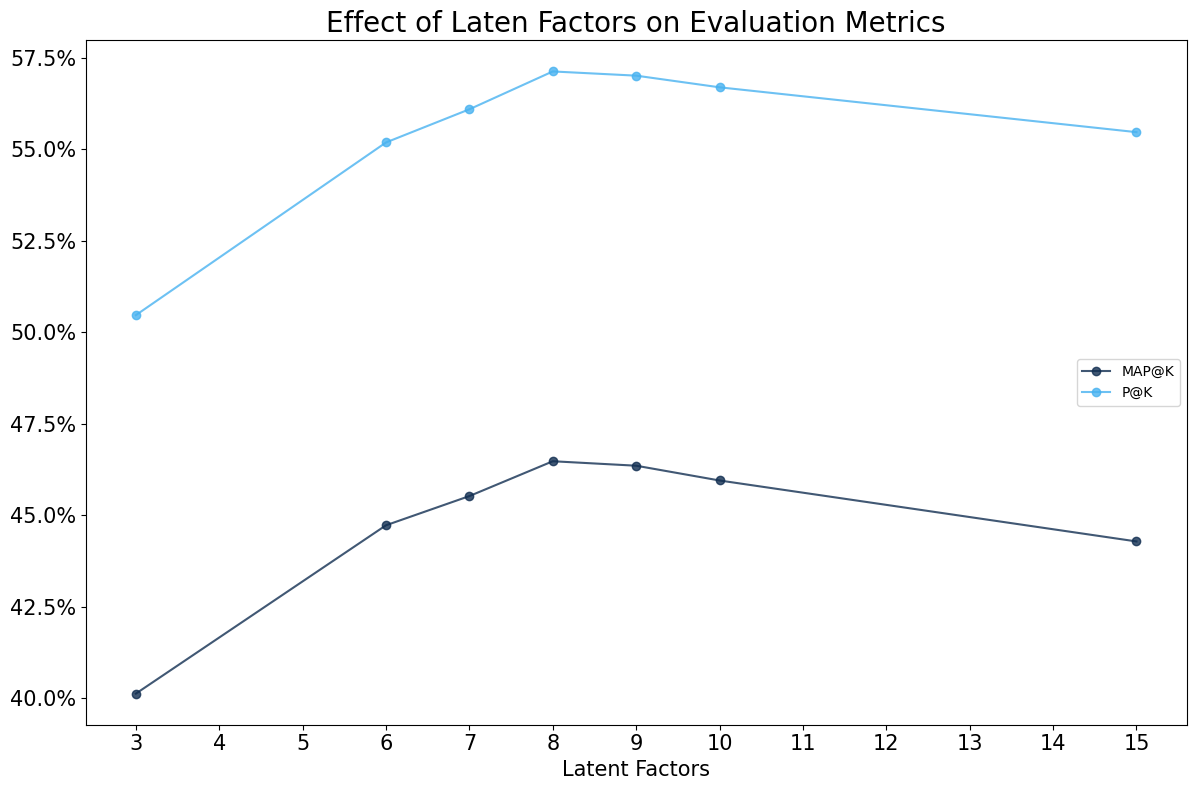

In [51]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
plt.plot(results_plot.factors,results_plot.map_at_k  ,color="#112e51",alpha=0.8, marker="o",label="MAP@K")
plt.plot(results_plot.factors,results_plot.precision_at_k  ,color="#48b2f0",alpha=0.8, marker="o",label="P@K")
plt.title("Effect of Laten Factors on Evaluation Metrics",size = 20)
plt.xlabel("Latent Factors",size=15)
plt.xticks(np.arange(3,16,1),fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc= "right")
plt.tight_layout()
ax.yaxis.set_major_formatter(mtick.PercentFormatter( xmax=1))
#plt.savefig("Evaluation of ALS Model with Different Factors.png",dpi=300)


**Description and Interpretation:** <br>
The figure "Effect of Latent Factors on Evaluation Metrics" shows on the one hand that the precision at k is always higher than the MAP. Although the values of both metrics differ, the shapes of the plots representing precision at k and MAP are similar or almost congruent. On the other hand, the figure shows that precision and map increase continuously as the number of latent factors increases until a high point is reached with 8 latent factors. If the number of latent factors is greater than 8, precision and MAP decrease, albeit only slightly. This behavior of the evaluation metrics can be explained by the fact that the model overfits on the data used for training as soon as more than 8 latent factors are set up. Due to the overfitting, the model ultimately achieves worse results on the unseen test data

### Initiate the best model

Get the representation of the data, that performed the best (raw, normalized, tf-idf or bm25)

In [52]:
best_grid_bm25  = { 'X': data_skills_csr,
                    'K1': best_model["K1"], 
                    'B': best_model["B"] 
                    }

In [53]:
data_representation_dict  = {'Raw':data_skills_csr
                            ,'Normalized':  implicit.nearest_neighbours.normalize(data_skills_csr)
                            , 'tfidf':implicit.nearest_neighbours.tfidf_weight(data_skills_csr)
                            , 'bm25':implicit.nearest_neighbours.bm25_weight(**best_grid_bm25)
                            }    

In [54]:
best_data = data_representation_dict[best_model["data_representations"]]
best_data = best_data.tocsr()

Initiate a train-test-split:

In [55]:
train_mat, test_mat = implicit.evaluation.train_test_split(best_data, train_percentage =  0.8, random_state = 42)

### Initiate that model

In [56]:
def initiate_best_model(key:str , model_params:pd.Series, data:csr_matrix):
    '''
    This function initiates a model based on the algorithm, that is represented by the parameter 'key'.
    The model will be initiated with the given parameters and will be fitted on the given data. 
    ----------
    Parameters: 
    key: str 
    A string that determines which algorithm will be used.
    model_params : pd.Series 
    A pandas Series holding the parameters for the algorithm.
    data : csr_matrix
    The trainingsdata to fit the model on. 
    ----------
    Returns: 
    - A fitted model of the implicit library, that is initiated with and fitted on the given data. This model can be used to recommend skills to users.
    '''
    if key == 'als':
        model = implicit.als.AlternatingLeastSquares(factors = model_params["factors"], regularization = model_params["regularization"], iterations = model_params["iterations"],  random_state= 42) #,alpha= model_params["alpha"]
    elif key == 'lmf':
        model = implicit.lmf.LogisticMatrixFactorization(factors = model_params["factors"], regularization = model_params["regularization"], iterations = model_params["iterations"], random_state= 42)#,alpha= model_params["alpha"]
    elif key == 'bpr':
        model = implicit.bpr.BayesianPersonalizedRanking(factors = model_params["factors"], regularization = model_params["regularization"], iterations = model_params["iterations"], random_state= 42)
    model.fit(data, show_progress= False)
    return model

In [57]:
model = initiate_best_model(best_key, best_model, train_mat)

## Evaluation

Comparing the model to the baseline of most often occuring skills:

In [58]:
def prec_at_k(actual:list, predicted:list, k:int=5):
    """
    Computes the precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0
        
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            score += 1.0
    return score / min(len(actual), k)
    

In [59]:
def average_precision_at_k(actual:list, predicted:list, k:int=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

In [60]:
def baseline_at_k(n):
    '''
    This function calculates the precision and MAP at k for the baseline model "most common skills",
    which is a simple recommendation strategy that involves recommending the most popular or frequent skills to all users.
    ----------
    Parameters: 
    k: int 
    The number of recommended skills per user.
    ----------
    Returns: 
    - The precision at k for the baseline model.
    '''
    #########
    # Get the most common skills
    #########
    most_common_skills = data_skills.sum(axis=0).nlargest(n).index.to_list()	


    #########
    # Create a list to store the precision at k for each user
    #########
    p_at_baseline_list  = np.zeros(len(PERSONS))
    map_at_baseline_list = np.zeros(len(PERSONS))

    for i in range(0,len(PERSONS)):

        #########
        # Get all user-item-interactions for a user within the test set
        #########
        user_series = pd.DataFrame.sparse.from_spmatrix(test_mat, columns=data_skills.columns).loc[i]

        #########
        # Get all user-item-interactions > 0 for a user
        #########
        user_known_skills = user_series[user_series > 0]

        user_known_skills = user_known_skills.index.to_list()

        p_at_baseline_list[i] = prec_at_k(user_known_skills, most_common_skills, k=n)
        map_at_baseline_list[i] = average_precision_at_k(user_known_skills, most_common_skills, k=n)
    return p_at_baseline_list.mean(), map_at_baseline_list.mean()


Precision at k = 10 of the baseline:

In [61]:
baseline_p_at_10 , basline_map_at_10 = baseline_at_k(10)

In [62]:
print(f'The precision at 10f or the baseline model is {round(baseline_p_at_10*100,2)}%. The MAP at 10 for the baseline model is {round(basline_map_at_10*100,2)}%')

The precision at 10f or the baseline model is 15.94%. The MAP at 10 for the baseline model is 7.1%


Precision at k = 10 of our model

In [63]:
model_p_at_10 =  implicit.evaluation.precision_at_k(model, train_user_items=train_mat, test_user_items=test_mat, K=10,show_progress=False)
model_map_at_10 =  implicit.evaluation.mean_average_precision_at_k(model, train_user_items=train_mat, test_user_items=test_mat, K=10,show_progress=False)

In [64]:
print(f'The precision at 10 for our best model is {round(model_p_at_10*100,2)}%. The MAP at 10 for our best model is {round(model_map_at_10*100,2)}%')

The precision at 10 for our best model is 52.96%. The MAP at 10 for our best model is 36.97%


Precision at k = 5 of the baseline:

In [65]:
baseline_p_at_5 , basline_map_at_5 = baseline_at_k(5)

In [66]:
print(f'The precision at 5 for the baseline model is {round(baseline_p_at_5*100,2)}%. The MAP at 5 for the baseline model is {round(basline_map_at_5*100,2)}%')

The precision at 5 for the baseline model is 15.95%. The MAP at 5 for the baseline model is 9.21%


Precision at k = 5 of our model:

In [67]:
model_p_at_5 =  implicit.evaluation.precision_at_k(model, train_user_items=train_mat, test_user_items=test_mat, K=5,show_progress=False)
model_map_at_5 =  implicit.evaluation.mean_average_precision_at_k(model, train_user_items=train_mat, test_user_items=test_mat, K=5,show_progress=False)

In [68]:
print(f'The precision at 5 for our best model is {round(model_p_at_5*100,2)}%. The MAP at 5 for our best model is {round(model_map_at_5*100,2)}%')

The precision at 5 for our best model is 56.14%. The MAP at 5 for our best model is 45.32%


**Comparison between our model and the baseline:**  <br>
Choosing k = 5, the baseline of most common skills achieves a Precision of 15.95\% and a MAP of 9.21\%. In contrast, our model has a Precision of 56.14\% and a MAP of 45.32\% and therefore performs significantly better than the baseline, where the recommendations are additionally differentiated and personalized. This demonstrated how a recommender system that processes implicit feedback can be successfully calibrated to suggest skills for employee trainin

## Recommendations

### Get Recommendations for a known user

Create a dictonary that holds the id of a skill as key and the name of a skill as value. <br>
This function is necassary to exclude certain skills from the recommendations later on.

In [69]:
# Id and skills
dict_skills_id = {}
for c,skill in enumerate(data_skills.columns):
        dict_skills_id[c] = skill

In [70]:
def get_key_from_value(dictonary: dict, values:list):
    '''
    This function returns the key of a dictionary, that is associated with the given value. 
    ----------
    Parameters: 
    dict_skills_id: dict 
    A dictionary with skills as keys and ids as values.
    values : str 
    A string that is associated with a key in the dictionary.
    ----------
    Returns: 
    - A list holding the keys to the corresponding values.
    '''
    output = [k for k,v in dictonary.items() for val in values if v == val]
    return output

In [71]:
def get_recommendations (model,userids:list, mat:csr_matrix ,eval_mat:csr_matrix = None ,items_to_exclude:list = None ,n:int = 5):
    '''
    This function produces recommendations for known user. 
    ----------
    Parameters: 
    model :
    A trained model from the implicit library.
    userids : list
    A list that holds the userids for which recommendations will be generated. 
    train_mat : csr_matrix
    A user-item matrix that holds the known items for the given users.
    test_mat : csr_matrix
    Optional: A user-item matrix that holds user-item interactions and can be used for evaluation.
    items_to_exclude : list
    Optional: A list that holds the items that should be excluded from the recommendations.
    n : int
    Optional: The number of recommendations that will be generated
    .
    ----------
    Returns: 
    - A pandas DataFrame that holds the recommendations for the given users.
    '''
    output = pd.DataFrame()
    if items_to_exclude is not None:
        items_to_exclude  = get_key_from_value(dict_skills_id,items_to_exclude)

    for u in userids:
        
        
        #############
        # Do recommendations for every user in the list. The known items are in the matrix the model was trained on
        #############

        skill_ids, scores  = model.recommend(u, user_items= mat[u], N = n , filter_already_liked_items=True, filter_items = items_to_exclude)
        recommendations_df = pd.DataFrame({"skill": [dict_skills_id[skill] for skill in skill_ids], "score": scores})

        #############
        # Get all known skills for each user by indexing the full data matrix
        #############
        
        if eval_mat is not None:
            eval_data = pd.DataFrame.sparse.from_spmatrix(data = eval_mat.tocsr()[u],columns=data_skills.columns).T.reset_index().rename(columns = {"index": "skill",0: "rating"}).sort_values(by = "rating", ascending = False)
   
            #############
            # Merge both df in order to see, if the recommended skills are the skills, which the user already knows, but were left out in the trainings data
            #############
            recommendations_df = recommendations_df.merge(eval_data, on = ["skill"], how = "left").rename(columns = {"rating": "rating_in_test_data"})


        #############
        # Merge the category information to the recommendations
        #############
        recommendations_df = recommendations_df.merge(data_categories, on = "skill", how = "left")
        recommendations_df["user_id"]  = u
        recommendations_df = recommendations_df.set_index("user_id")
        output = pd.concat([output, recommendations_df])
    
    return output

In [72]:
userid= [0]
get_recommendations(model, userid, train_mat,test_mat,  n = 5)


,skill,score,rating_in_test_data,category
user_id,,,,
0,REST,0.885694,1,Standards
0,SCRUM,0.812002,1,Projektmanagement / Vorgehensmodelle
0,Unit Tests (Komponententests),0.803812,1,Methoden und Praktiken
0,MySQL,0.704764,1,Datenbank
0,Windows 7,0.662781,1,Betriebssystem


### Plotting the recommendations in the context of users main category

Get recommendations for every employee:

In [73]:
occurence = np.zeros(len(PERSONS))
for i,p in enumerate(PERSONS):
    main_cat = df[df["person"] == p]["category"].value_counts().index[0]
    recommended_cat = get_recommendations(model, [i], train_mat, items_to_exclude = ["SCRUM"], n = 10)["skill"].apply(lambda x : category_dict[x]).to_numpy()
    count = 0
    for cat in recommended_cat:
        if cat == main_cat:
            count += 1
    occurence[i] = count

In [74]:
occurence.shape

(404,)

Check if the recommendations are skills of a users main category:

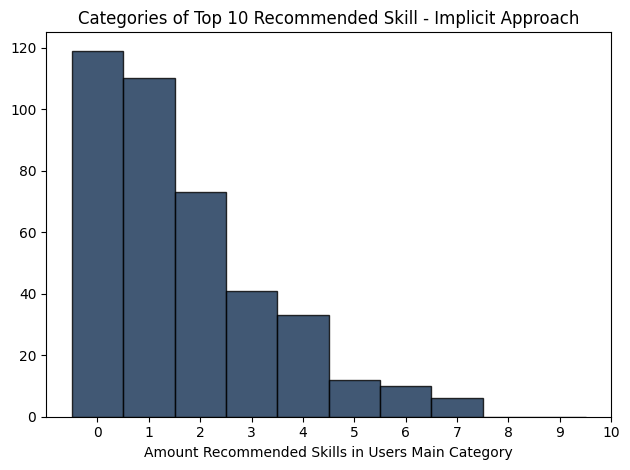

In [75]:
plt.hist(occurence,color="#112e51",alpha=0.8,edgecolor='k',align="left", bins=range(11))
plt.title("Categories of Top 10 Recommended Skill - Implicit Approach")
plt.xlabel("Amount Recommended Skills in Users Main Category")
plt.xticks(np.arange(0,11,1))
plt.tight_layout()
plt.savefig("categories_of_top_10_recommended_skill_binary.png",dpi=300)

**Description and Interpretation:** <br>
The visualization displays in how far the recommendations depend on the main category of each user which is defined as the category, which makes up the relative majority of a user’s skills. <br>
As seen in the plot above, the recommendations of the implicit model have little to no connection to the main category of the users. This is expressed by the fact that the majority of users receive two or less recommendation which are from their main category. This observation leads to the assumption that the recommendations of the implicit approach follow a rather explorative approach and do not delve into the exact skill field a user is already experienced in.

### Get recommendations for a new user

Initiate a new user 

In [76]:
new_id = 404
new_skills = {
                "Englisch":1,
                "Deutsch":1,
                "Python":1,
                "MySQL":1,
                "MongoDB":1,
                "vs code":1,
                "Docker":1,
                "GIT":1,
                "GitHub":1
            }

Initiate a new user. For sake of qualitative evaluation, we initiate a stereotypical datascience student as new user: 

In [77]:
def get_recommendations_new_user(model, userid:int, user_skills:dict, old_user_mat:csr_matrix, items_to_exclude:list = None ,n:int = 5):
    '''
    This function produces recommendations for a new user. 
    ----------
    Parameters: 
    model :
    A trained model from the implicit library.
    userid : int
    The id of the new user. 
    user_skills : dict
    A dictonary contain.
    old_user_mat : csr_matrix
    Optional: A user-item matrix on which the model was trained on.
    items_to_exclude : list
    Optional: A list that holds the items that should be excluded from the recommendations.
    n : int
    Optional: The number of recommendations that will be generated
    .
    ----------
    Returns: 
    - A pandas DataFrame that holds the recommendations for a new users.
    '''
    if items_to_exclude is not None:
        items_to_exclude  = get_key_from_value(dict_skills_id,items_to_exclude)
    #############
    # Create a new user as dataframe, where a row represents a user and the columns represent the skills of that user
    #############
    new_user = pd.DataFrame(user_skills, index = [userid])


    #############
    # Append the new user to the old user matrix and fill the missing values with 0
    #############
    mat = pd.concat([old_user_mat,new_user]).sort_index().fillna(0).astype(int)
    mat = scipy.sparse.csr_matrix(mat.values)

    #############
    # Transform the matrix which contains the new user according to the results of the grid search
    #############
    best_grid_bm25  = { 'X': mat, 'K1': best_model["K1"], 'B': best_model["B"] }
    
    data_representation_dict  = {
                                'Raw':mat
                                ,'Normalized':  implicit.nearest_neighbours.normalize(mat)
                                ,'tfidf':implicit.nearest_neighbours.tfidf_weight(mat)
                                ,'bm25':implicit.nearest_neighbours.bm25_weight(**best_grid_bm25)
                                }   
 
    mat = data_representation_dict[best_model["data_representations"]]
    mat = mat.tocsr()

    #############
    # Do recommendations for the new user
    #############

    skill_ids, scores  = model.recommend(userid, user_items= mat[userid], N = n , filter_already_liked_items=True, filter_items = items_to_exclude, recalculate_user=True)
    recommendations_df = pd.DataFrame({"skill": [dict_skills_id[skill] for skill in skill_ids], "score": scores})

    #############
    # Merge the category information to the recommendations
    #############
    recommendations_df = recommendations_df.merge(data_categories, on = "skill", how = "left")
    recommendations_df["user_id"]  = userid
    recommendations_df = recommendations_df.set_index("user_id")
 
    return recommendations_df

In [78]:
get_recommendations_new_user(model,new_id, new_skills, data_skills,items_to_exclude = ["SCRUM"], n = 5)

,skill,score,category
user_id,,,
404,Gitlab,0.173373,"CI/CD, Build- und Versionskontrollsysteme"
404,JavaScript,0.162671,Programmiersprachen / Scriptsprachen
404,Java,0.159152,Programmiersprachen / Scriptsprachen
404,SQL,0.151486,Datenbank
404,JIRA,0.147411,Issue Management


**Interpretation of the recommendations:** <br>
Looking at the recommendations produced by ALS using implicit user feedback, the recommended skills make the impression to harmonize with the already possessed skills of the data science student. This is due to the fact that the recommendations Gitlab and SQL can be seen as additions to the already known skills GIT, Github and MySQL. On top of that, recommending popular programming languages, such as JavaScript and Java can be seen as promising, since the user might want to catch up on an additional programming language to round up the individual skill portfolio.

## Conclusion:

The implicit approach produced the best results using the Alternating Least Squares algorithm, using matrix factorization with 8
latent factors, scoring a P@K of 57,12% and a MAP@K of 46,47%. Since the precision of the model is very high compared to the baseline "most common skills", the modeling of the recommender at the quantitative level can be rated as successful.  <br> Furthermore, the qualitative evaluation showed that complementary and meaningful skills were generated for the stereotypical data science student. For this reason the modeling of the recommender at the quantitative level can be rated as successful aswell. <br>
In conclusion, it can be stated that this notebook demonstrates how a recommender system that processes implicit feedback can be successfully calibrated to suggest skills for employee training.

## Appendix I - Effect of Dropping Rare Skills on Recommender Precision

By dropping skills we can investigate the tradeoff between a matrix with a higher level of density and the removal of distinguishing features.

Infos best model:

In [79]:
best_model

data_representations         Raw
K1                           NaN
B                            NaN
factors                        8
regularization             0.005
iterations                    10
precision_at_k          0.571195
map_at_k                 0.46472
Name: 27, dtype: object

In [80]:
def measure_performance_for_n(min_support:list):
    '''
    This function measures the performance of a recommender system across matrices with a different level of sparsity. 
    ----------
    Parameters: 
    min_support : list
    A list of integers that represent the minimum absolute support threshold. Items/ skills with a lower absolute support will be removed from the dataset.
    ----------
    Returns: 
    - A pandas DataFrame that demonstrates the effect of the sparsity on the performance of the recommender system (c.p.).
    '''
    output = pd.DataFrame()
    for n in min_support:
        #############
        # Import the data
        #############
        df = pd.read_csv("data/person-skills_2022-06-27.csv",sep=";") 

        #############
        # trim dataset according to min absolute support of skills and insert ratings afterwards
        #############
        rare_skills = get_rare_skills(df,n)
        df = df[~df["skill"].isin(rare_skills)]
        unique_skills = df["skill"].nunique()

        #############
        # Create a user-item matrix
        #############
        df["count"] = 1
        matrix = df.pivot_table('count', index='person', columns="skill").fillna(0).astype(int).reset_index(drop=True)
        matrix.index.names = ["userids"]
        matrix_csr = scipy.sparse.csr_matrix(matrix.values)
        
        #############
        # Measure sparsity (ratio between non-zero and zero value entries) of the trainset
        #############
        number_of_elements_in_matrix = matrix_csr.shape[0] * matrix_csr.shape[1]
        number_of_nonzeros_in_matrix = matrix_csr.sum()

        sparsity = 1 - number_of_nonzeros_in_matrix/number_of_elements_in_matrix
        sparsity = round(sparsity,4)
        #############
        # Split the data into train and test set
        #############
        train_mat, test_mat = implicit.evaluation.train_test_split(matrix_csr, train_percentage =  0.8, random_state = 42)



        #############
        # Initialize the model
        #############
        model = initiate_best_model(best_key, best_model, train_mat)

        
        prec_at_k = implicit.evaluation.precision_at_k(model, train_mat, test_mat, K = 5, show_progress = False)
        map_at_k = mean_average_precision_at_k(model, train_mat, test_mat, K = 5, show_progress = False)
        result = pd.DataFrame({
                                "unique_skills":unique_skills
                                ,"sparsity": sparsity
                                ,"precision_at_k": prec_at_k
                                ,"map_at_k": map_at_k
                                }, index = [n])

        result.index.names = ["min_support"] 
        output = pd.concat([output,result])


    return output

Minimum absolute support:

In [81]:
min_absolute_support = [0, 1, 2, 5, 10, 20]

In [82]:
measure_performance_for_n(min_absolute_support)

,unique_skills,sparsity,precision_at_k,map_at_k
min_support,,,,
0,734,0.9185,0.561434,0.453216
1,665,0.9101,0.592947,0.479543
2,614,0.9028,0.596108,0.489971
5,510,0.8849,0.568033,0.454784
10,392,0.8558,0.574216,0.465308
20,270,0.8052,0.592089,0.473529


**Conclusion regarding the effect of dropping rare skills:** <br>
We can observe, that lowering the sparsity of a matrix does not necessarily lead to a higher precision at k score. 
Nevertheless it can still increase the precision at k slightly, but it is important to know that items removed from the dataset will no longer appear in the recommendations. Therefore it is often useful to experiment with different minimum support values to find the optimal balance between diversity and relevance in the recommendations.

## Appendix II -  Reverse Problem for User Recommendations on Items

Transpose the user-item-matrix in order to get a item-user matrix and use the transformation technique on it, that achieved the best results:

In [83]:
data_best_u = implicit.nearest_neighbours.bm25_weight(data_skills_csr.T, K1 = 100, B = 0.8)
data_best_u = data_best_u.tocsr()
data_best_u

<734x404 sparse matrix of type '<class 'numpy.float64'>'
	with 24156 stored elements in Compressed Sparse Row format>

train-test-split:

In [84]:
train_mat_u, test_mat_u = implicit.evaluation.train_test_split(data_best_u, train_percentage =  0.8, random_state = 42)

fit the model:

In [85]:
model_best_u = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01, iterations = 15,random_state = 42)# alpha = 1, 
model_best_u.fit(train_mat_u)

100%|██████████| 15/15 [00:00<00:00, 35.48it/s]


In [86]:
def get_recommendations_reversed (model,skillids:list, mat:csr_matrix ,eval_mat:csr_matrix = None ,items_to_exclude:list = None ,n:int = 5):
    '''
    This function recommends,which users are most likely qualified to learn a certain skill. 
    ----------
    Parameters: 
    model :
    A trained model from the implicit library.
    skillids : list
    A list that holds the skill ids for which recommendations will be generated. 
    mat : csr_matrix
    A item-user matrix that holds the known users for the given skill.
    eval_mat : csr_matrix
    Optional: A item-user matrix that holds item-user interactions and can be used for evaluation.
    items_to_exclude : list
    Optional: A list that holds the users, who should be excluded from the recommendations.
    n : int
    Optional: The number of recommendations that will be generated
    .
    ----------
    Returns: 
    - A pandas DataFrame that holds the recommendations for the given skill.
    '''
    output = pd.DataFrame()

    
    #skillids  = get_key_from_value(dict_skills_id,skillids)
    #skillids = [s[0] for s in skillids]
    for value in skillids:
        key  = get_key_from_value(dict_skills_id,[value])
        key = key[0]
        #############
        # Do recommendations for every user in the list. The known items are in the matrix the model was trained on
        #############

        user_ids, scores  = model.recommend(key, user_items= mat[key], N = n , filter_already_liked_items=True, filter_items = items_to_exclude)
        recommendations_df = pd.DataFrame({"user_id": user_ids, "score": scores})

        #############
        # Get all known skills for each user by indexing the full data matrix
        #############
        
        if eval_mat is not None:
            eval_data = pd.DataFrame.sparse.from_spmatrix(data = eval_mat.tocsr()[s],columns=data_skills.columns).T.reset_index().rename(columns = {"index": "user_id",0: "rating"}).sort_values(by = "rating", ascending = False)
   
            #############
            # Merge both df in order to see, if the recommended skills are the skills, which the user already knows, but were left out in the trainings data
            #############
            recommendations_df = recommendations_df.merge(eval_data, on = ["user_id"], how = "left").rename(columns = {"rating": "rating_in_test_data"})



        recommendations_df["skill_id"]  = value
        recommendations_df = recommendations_df.set_index("skill_id")
        output = pd.concat([output, recommendations_df])
        
    return output

In [87]:
get_recommendations_reversed(model_best_u, ["Python","Java"],train_mat_u)

,user_id,score
skill_id,,
Python,270,0.713534
Python,12,0.673033
Python,309,0.659310
Python,392,0.614753
Python,47,0.506845
Java,239,0.869117
Java,316,0.688858
Java,241,0.676700
Java,353,0.638023


## Appendix III - Similarities

This section introduces the function of the recommender system, which outputs similar users or skills according to the input

### Items
The function dealing with similar skills can be used to evaluate the quality of the recommender system.  If sufficient domain knowledge is available, a known skill can be passed to the recommender in order to subsequently assess to what extent the skills declared as similar are actually similar.

In [88]:
def get_similar_items(skill:str, n:int = 5):
    skillid = get_key_from_value(dict_skills_id,[skill])[0]
    skill_id, sim = model.similar_items(skillid, N=n)
    # display the results using pandas for nicer formatting
    similarity_df  = pd.DataFrame({"skill": data_skills.columns[skill_id], "score": sim})
    similarity_df = similarity_df.merge(data_categories, how = "left", left_on = "skill", right_on = "skill")
    return similarity_df

In [89]:
get_similar_items("SQL") 

,skill,score,category
0,SQL,1.000000,Datenbank
1,Unit Tests (Komponententests),0.893558,Methoden und Praktiken
2,REST,0.872100,Standards
3,JSON,0.868121,Webentwicklung
4,Test Driven Development (TDD),0.853206,Methoden und Praktiken


### User Similarities

However, from the company's point of view, the function that issues similar employees is much more interesting. Since the company is in the project business, the problem of an employee being absent due to illness can easily arise. Now the company is faced with the challenge of replacing the employee adequately with another employee so that the project can be completed successfully. Through the addressed function, the company can be suggested which employees are most suitable to replace the absent employee based on their skill portfolio. 

In [90]:
userid_dictonary =  [dict((k,v) for k,v in enumerate(PERSONS))][0]

In [91]:
new_skills = {
                "Windows 11":1,
                "Englisch":1,
                "Chinesisch (Mandarin)":1,
                "Python":1,
                "MATLAB":1,
                "Java":1,
                "MySQL":1,
                "SQLBase":1,
                "Microsoft SQL Server":1,
                "Google Cloud Platform":1,
                "MongoDB":1,
                "JSON":1,
                "Docker":1,
                "Statische Codeanalyse": 1,
                "Power BI":1,
                "Postman":1,
                "PowerShell":1,
                "Github actions":1
            }

In [92]:
new_user_id_list = list(new_skills.keys())

In [93]:
def get_similar_users(userid:int, n:int = 5):
    
    user_id, sim = model.similar_users(userid, N=n)
    # display the results using pandas for nicer formatting
    similarity_df  = pd.DataFrame({"user": [userid_dictonary[u] for u in user_id], "score": sim})
    return similarity_df

In [94]:
get_similar_users(0)

,user,score
0,12,1.000000
1,318,0.966558
2,1488,0.954939
3,798,0.944366
4,194,0.933300


In [95]:
def evaluate_employee_recoms(userid:int , second_userid:int):
    '''
    Function showing recommendation along with actually possessed skills and categories to provide some context.  
    ----------
    Parameters: 
    userid : int
    The user id of the employee who's recommendation are to be evaluated.  
    n : int 
    Amount recommendation and skills to be shown. 
    ----------
    Returns: 
    DataFrame containing recommendations and actually possessed skills.  
    '''
    fig, ax1 = plt.subplots(1, 1)
    skill_catgegories = df[df["person"] == userid]["category"].value_counts()

    # Plot the first dataset on the first subplot

    skill_catgegories_second_user = df[df["person"] == second_userid]["category"].value_counts()
    
    # reducte the categories of user 2 to the categories of user 1
    skill_catgegories_second_user = skill_catgegories_second_user[skill_catgegories_second_user.index.isin(skill_catgegories.index)]

    # Merge the two datasets
    comparison_df = pd.concat([skill_catgegories,skill_catgegories_second_user,], axis=1)
    comparison_df.columns = [f"user {userid}", f"user {second_userid}"]

    comparison_df.plot(kind="barh", ax=ax1)
    ax1.set_title("Comparison of skills of two employees")
    ax1.set_xlabel("Amount of skills in category")
 #   plt.tight_layout()
#    plt.savefig("Comparison of skills of two employees.png",dpi=300)
    return  

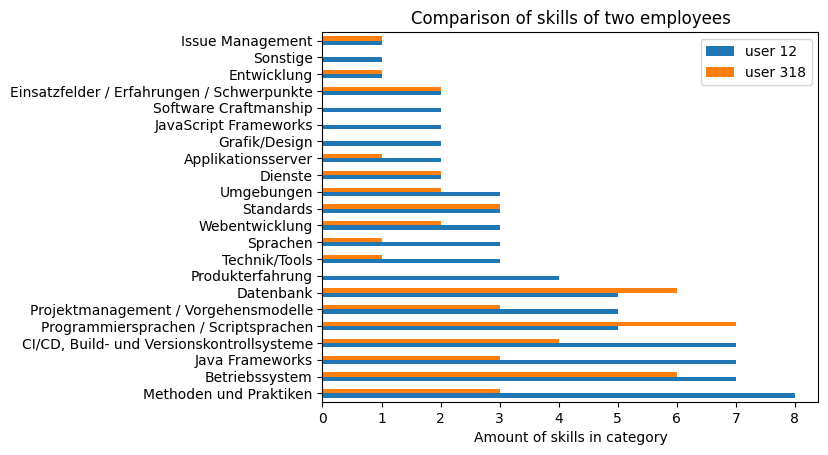

In [96]:
evaluate_employee_recoms(12,318)

**Description and Interpretation:** <br>
The visualization contrasts a user (ID = 12) with his most similar user (ID = 318) according to the recommender system. For the sake of simplicity, the employee with ID = 12 will be understood as "employee" and the user with ID = 318 will be understood as "representative" in the following. The comparison of both users is based on the skills and skill categories of the employee. While the Y-axis shows the employee's skill categories, the X-axis represents how many skills the employee or representative has in the respective category. The visualization shows that the representative possesses skills in 17 of the 22 categories listed, which tends to indicate that the representative is to some extent similar to the employee in terms of skills. In order to be able to make a final assessment of how similar employees and representatives really are, a detailed analysis must be carried out at the skill level by a person with sufficient domain knowledge. Nevertheless, the Recommender system offers a good first point of reference for finding adequate replacements for an employee.